In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
car_dataset.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,low,2,more,med,low,unacc
1,vhigh,vhigh,2,4,big,med,unacc
2,high,high,2,more,small,med,unacc
3,high,med,5more,more,med,med,acc
4,med,med,5more,more,big,low,unacc


### Car 70%

unacc    588
acc      158
good      33
vgood     26
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

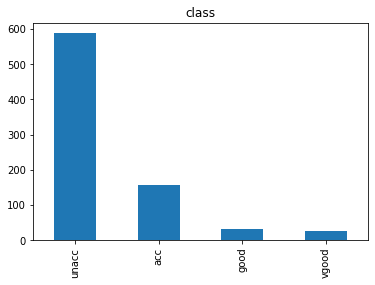

In [7]:
car_set_for_training70, car_testing70 = data_utils.data_split(car_dataset, 70)
car_training70, car_validation70 = data_utils.split_training_data_for_pruning(car_set_for_training70)
print(car_training70['CLASS'].value_counts())
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [ ]:
# car_training

158


<AxesSubplot:title={'center':'class'}>

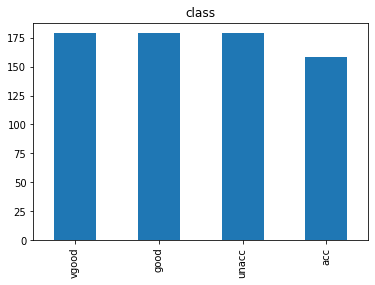

In [8]:
#Target for all 174
resampling_car70 = car_training70.copy()
unacc_part70 = resampling_car70[resampling_car70['CLASS'] == 'unacc']
acc_part70 = resampling_car70[resampling_car70['CLASS'] == 'acc'] 
print(len(acc_part70))
vgood_part70 = resampling_car70[resampling_car70['CLASS'] == 'vgood'] 
good_part70 = resampling_car70[resampling_car70['CLASS'] == 'good'] 


unacc_downsample70 = resample(unacc_part70, 
                                 replace=False,     
                                 n_samples=179)

vgood_part_upsampled70 = resample(vgood_part70, 
                                 replace=True,     
                                 n_samples=179)
good_part_upsampled70 = resample(good_part70, 
                                 replace=True,     
                                 n_samples=179)

# Combine majority class with upsamplet minority class
balanced_car_training70 = pd.concat([unacc_downsample70, acc_part70, vgood_part_upsampled70, good_part_upsampled70])
balanced_car_training70 = balanced_car_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training70 = balanced_car_training70.sample(frac=1).reset_index(drop=True)

car_training70 = balanced_car_training70.copy()
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [ ]:
car_training70.head()

### Dataset 80%

unacc    667
acc      188
good      37
vgood     29
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

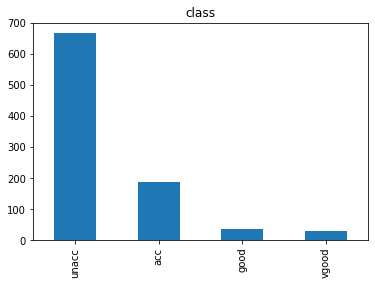

In [9]:
car_set_for_training80, car_testing80 = data_utils.data_split(car_dataset, 80)
car_training80, car_validation80 = data_utils.split_training_data_for_pruning(car_set_for_training80)
print(car_training80['CLASS'].value_counts())
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [ ]:
# car_training80

<AxesSubplot:title={'center':'class'}>

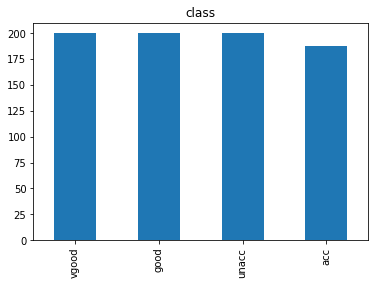

In [10]:
#Target for all 318
resampling_car80 = car_training80.copy()
unacc_part80 = resampling_car80[resampling_car80['CLASS'] == 'unacc']
acc_part80 = resampling_car80[resampling_car80['CLASS'] == 'acc'] 
vgood_part80 = resampling_car80[resampling_car80['CLASS'] == 'vgood'] 
good_part80 = resampling_car80[resampling_car80['CLASS'] == 'good'] 


unacc_downsample80 = resample(unacc_part80, 
                                 replace=False,     
                                 n_samples=200)

vgood_part_upsampled80 = resample(vgood_part80, 
                                 replace=True,     
                                 n_samples=200)
good_part_upsampled80 = resample(good_part80, 
                                 replace=True,     
                                 n_samples=200)

# Combine majority class with upsamplet minority class
balanced_car_training80 = pd.concat([unacc_downsample80, acc_part80, vgood_part_upsampled80, good_part_upsampled80])
balanced_car_training80 = balanced_car_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training80 = balanced_car_training80.sample(frac=1).reset_index(drop=True)

car_training80 = balanced_car_training80.copy()
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [ ]:
# car_training80.head()

### Dataset 90%

unacc    739
acc      219
good      42
vgood     36
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

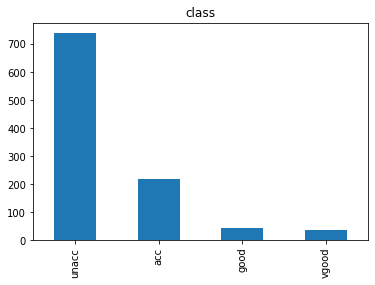

In [11]:
car_set_for_training90, car_testing90 = data_utils.data_split(car_dataset, 90)
car_training90, car_validation90 = data_utils.split_training_data_for_pruning(car_set_for_training90)
print(car_training90['CLASS'].value_counts())
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

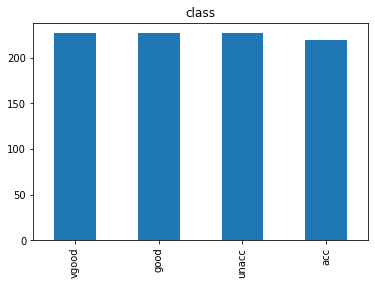

In [12]:
#Target for all 352?
resampling_car90 = car_training90.copy()
unacc_part90 = resampling_car90[resampling_car90['CLASS'] == 'unacc']
acc_part90 = resampling_car90[resampling_car90['CLASS'] == 'acc']
vgood_part90 = resampling_car90[resampling_car90['CLASS'] == 'vgood'] 
good_part90 = resampling_car90[resampling_car90['CLASS'] == 'good'] 


unacc_downsample90 = resample(unacc_part90, 
                                 replace=False,     
                                 n_samples=227)

vgood_part_upsampled90 = resample(vgood_part90, 
                                 replace=True,     
                                 n_samples=227)
good_part_upsampled90 = resample(good_part90, 
                                 replace=True,     
                                 n_samples=227)

# Combine majority class with upsamplet minority class
balanced_car_training90 = pd.concat([unacc_downsample90, acc_part90, vgood_part_upsampled90, good_part_upsampled90])
balanced_car_training90 = balanced_car_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training90 = balanced_car_training90.sample(frac=1).reset_index(drop=True)

car_training90 = balanced_car_training90.copy()
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

In [ ]:
# car_training90

## Model Training

In [ ]:
train_tree_for_different_heuristics(car_training70, car_testing70, car_validation70)

In [ ]:
train_tree_for_different_heuristics(car_training80, car_testing80, car_validation80)

In [ ]:
train_tree_for_different_heuristics(car_training90, car_testing90, car_validation90)

# Cancer Dataset

# Dataset preparation

In [13]:
cancer_dataset_path = 'data/breast-cancer.data'
cancer_dataset_labels = ['CLASS','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast', 'breast-quad', 'irradiat']
cancer_dataset = data_utils.preapare_dataset(cancer_dataset_path, cancer_dataset_labels)
cancer_dataset = cancer_dataset[['age','menopause','tumor-size','inv-nodes', 'node-caps','deg-malig','breast', 'breast-quad', 'irradiat', 'CLASS']]
# cancer_dataset.head()
cancer_dataset

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,CLASS
0,30-39,premeno,35-39,9-11,yes,3,left,left_low,no,recurrence-events
1,50-59,ge40,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
2,50-59,ge40,25-29,0-2,no,3,left,right_up,no,no-recurrence-events
3,60-69,ge40,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
4,60-69,ge40,10-14,0-2,no,1,left,left_up,no,no-recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,70-79,ge40,40-44,0-2,no,1,right,right_up,no,no-recurrence-events
282,40-49,premeno,20-24,3-5,yes,2,left,left_low,yes,recurrence-events
283,40-49,premeno,30-34,0-2,no,2,right,right_low,no,no-recurrence-events
284,60-69,ge40,30-34,3-5,yes,2,left,central,yes,recurrence-events


### Cancer 70%

no-recurrence-events    89
recurrence-events       44
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

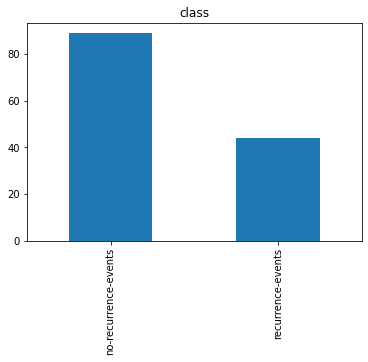

In [14]:
cancer_set_for_training70, cancer_testing70 = data_utils.data_split(cancer_dataset, 70)
cancer_training70, cancer_validation70 = data_utils.split_training_data_for_pruning(cancer_set_for_training70)
print(cancer_training70['CLASS'].value_counts())
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

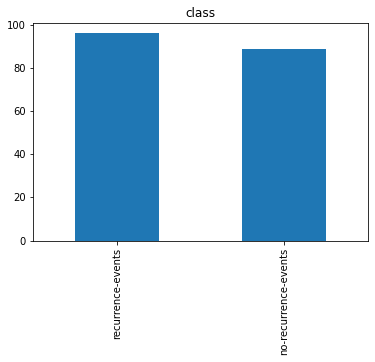

In [15]:
#Target for all 174
resampling_cancer70 = cancer_training70.copy()
recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'recurrence-events']
no_recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled70 = resample(recurrence_events_part70, 
                                 replace=True,     
                                 n_samples=96)

# Combine majority class with upsamplet minority class
balanced_cnacer_training70 = pd.concat([recurrence_events_part_upsampled70, no_recurrence_events_part70])
balanced_cnacer_training70 = balanced_cnacer_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training70 = balanced_cnacer_training70.sample(frac=1).reset_index(drop=True)

cancer_training70 = balanced_cnacer_training70.copy()
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 80%

no-recurrence-events    104
recurrence-events        47
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

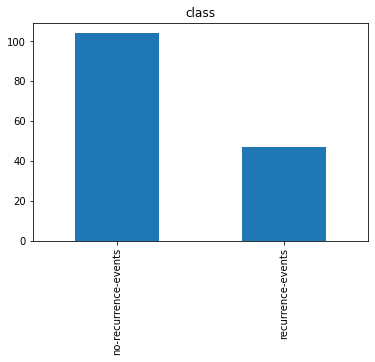

In [16]:
cancer_set_for_training80, cancer_testing80 = data_utils.data_split(cancer_dataset, 80)
cancer_training80, cancer_validation80 = data_utils.split_training_data_for_pruning(cancer_set_for_training80)
print(cancer_training80['CLASS'].value_counts())
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

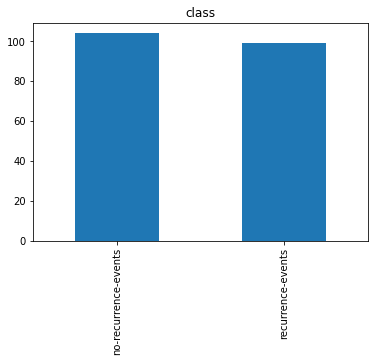

In [17]:
#Target for all 174
resampling_cancer80 = cancer_training80.copy()
recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'recurrence-events']
no_recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled80 = resample(recurrence_events_part80, 
                                 replace=True,     
                                 n_samples=99)

# Combine majority class with upsamplet minority class
balanced_cnacer_training80 = pd.concat([recurrence_events_part_upsampled80, no_recurrence_events_part80])
balanced_cnacer_training80 = balanced_cnacer_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training80 = balanced_cnacer_training80.sample(frac=1).reset_index(drop=True)

cancer_training80 = balanced_cnacer_training80.copy()
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 90%

no-recurrence-events    121
recurrence-events        50
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

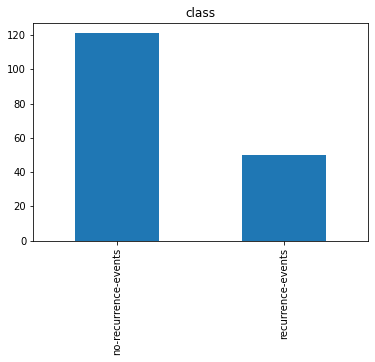

In [18]:
cancer_set_for_training90, cancer_testing90 = data_utils.data_split(cancer_dataset, 90)
cancer_training90, cancer_validation90 = data_utils.split_training_data_for_pruning(cancer_set_for_training90)
print(cancer_training90['CLASS'].value_counts())
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

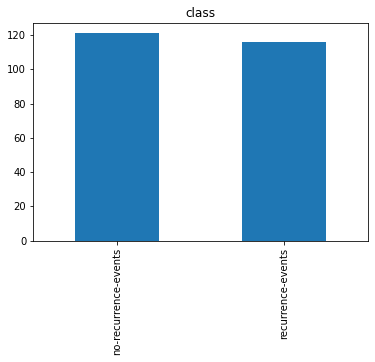

In [19]:

#Target for all 174
resampling_cancer90 = cancer_training90.copy()
recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'recurrence-events']
no_recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled90 = resample(recurrence_events_part90, 
                                 replace=True,     
                                 n_samples=116)

# Combine majority class with upsamplet minority class
balanced_cnacer_training90 = pd.concat([recurrence_events_part_upsampled90, no_recurrence_events_part90])
balanced_cnacer_training90 = balanced_cnacer_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training90 = balanced_cnacer_training90.sample(frac=1).reset_index(drop=True)

cancer_training90 = balanced_cnacer_training90.copy()
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [ ]:
train_tree_for_different_heuristics(cancer_training70, cancer_testing70, cancer_validation70)

In [ ]:
train_tree_for_different_heuristics(cancer_training80, cancer_testing80, cancer_validation80)

In [ ]:
train_tree_for_different_heuristics(cancer_training90, cancer_testing90, cancer_validation90)

# CMC Dataset

## Dataset preparation

In [20]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,39,3,4,3,1,1,1,4,0,1
1,46,4,4,4,1,1,1,4,0,2
2,38,4,4,6,1,1,2,4,0,3
3,38,4,4,3,1,0,1,4,0,2
4,49,3,4,5,1,1,1,4,0,1


In [21]:
vals_to_replace_education = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_husbandEducation = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_religion = {0: 'Non-Islam', 1:'Islam'}
vals_to_replace_isWorking = {0: 'Yes', 1:'No'}
vals_to_replace_livingStandard= {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_mediaExposure = {0: 'Good', 1:'Not good'}
vals_to_replace_CLASS = {1: 'No-use', 2:'Long-term', 3: 'Short-term'}
cmc_dataset['education'] = cmc_dataset['education'].map(vals_to_replace_education)
cmc_dataset['husbandEducation'] = cmc_dataset['husbandEducation'].map(vals_to_replace_husbandEducation)
cmc_dataset['religion'] = cmc_dataset['religion'].map(vals_to_replace_religion)
cmc_dataset['isWorking'] = cmc_dataset['isWorking'].map(vals_to_replace_isWorking)
cmc_dataset['livingStandard'] = cmc_dataset['livingStandard'].map(vals_to_replace_livingStandard)
cmc_dataset['mediaExposure'] = cmc_dataset['mediaExposure'].map(vals_to_replace_mediaExposure)
cmc_dataset['CLASS'] = cmc_dataset['CLASS'].map(vals_to_replace_CLASS)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,39,normal,high,3,Islam,No,1,high,Good,No-use
1,46,high,high,4,Islam,No,1,high,Good,Long-term
2,38,high,high,6,Islam,No,2,high,Good,Short-term
3,38,high,high,3,Islam,Yes,1,high,Good,Long-term
4,49,normal,high,5,Islam,No,1,high,Good,No-use


### Cmc 70%

No-use        287
Short-term    240
Long-term     160
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

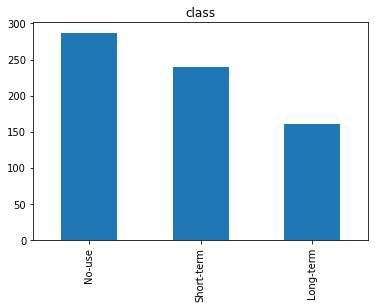

In [22]:
cmc_set_for_training70, cmc_testing70 = data_utils.data_split(cmc_dataset, 70)
cmc_training70, cmc_validation70 = data_utils.split_training_data_for_pruning(cmc_set_for_training70)
print(cmc_training70['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training70['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 80%

No-use        325
Short-term    276
Long-term     184
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

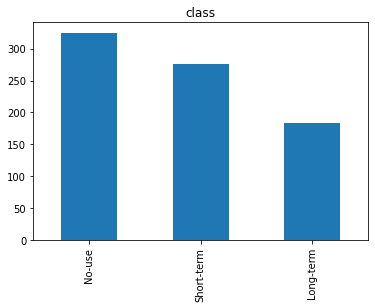

In [23]:
cmc_set_for_training80, cmc_testing80 = data_utils.data_split(cmc_dataset, 80)
cmc_training80, cmc_validation80 = data_utils.split_training_data_for_pruning(cmc_set_for_training80)
print(cmc_training80['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training80['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 90%

No-use        369
Short-term    311
Long-term     203
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

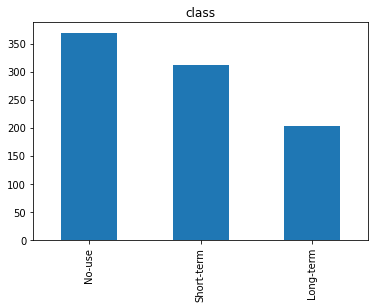

In [24]:
cmc_set_for_training90, cmc_testing90 = data_utils.data_split(cmc_dataset, 90)
cmc_training90, cmc_validation90 = data_utils.split_training_data_for_pruning(cmc_set_for_training90)
print(cmc_training90['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [ ]:
train_tree_for_different_heuristics(cmc_training70, cmc_testing70, cmc_validation70)

In [ ]:
train_tree_for_different_heuristics(cmc_training80, cmc_testing80, cmc_validation80)

In [ ]:
train_tree_for_different_heuristics(cmc_training90, cmc_testing90, cmc_validation90)

# Adult Dataset

## Data preparation

In [25]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,57,Private,74156,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,30,United-States,<=50K
1,32,Private,70985,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
2,44,?,268804,HS-grad,9,Married-civ-spouse,?,Husband,Black,Male,0,0,30,United-States,<=50K
3,27,Private,205440,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
4,50,Private,31621,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K


In [26]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week', 'native-country' ,'CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,57,Private,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,30,United-States,<=50K
1,32,Private,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,<=50K
2,44,?,HS-grad,9,Married-civ-spouse,?,Husband,Black,Male,30,United-States,<=50K
3,27,Private,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,<=50K
4,50,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,54,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,60,South,>50K
32557,25,Private,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,60,United-States,>50K
32558,23,Private,12th,8,Never-married,Handlers-cleaners,Own-child,Amer-Indian-Eskimo,Male,40,United-States,<=50K
32559,44,Local-gov,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K


In [27]:
adult_dataset.dropna(how='any', axis=0)
indexNames = adult_dataset[(adult_dataset['workclass'] == '?') | (adult_dataset['education'] == '?') | (adult_dataset['marital-status'] == '?') | (adult_dataset['occupation'] == '?') | (adult_dataset['relationship'] == '?') | (adult_dataset['race'] == '?') | (adult_dataset['sex'] == '?') | (adult_dataset['native-country'] == '?') ].index
# print(indexNames)
adult_dataset.drop(indexNames, inplace=True)
adult_dataset.head()
adult_dataset.reset_index(inplace=True)
adult_dataset

,index,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,0,57,Private,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,30,United-States,<=50K
1,1,32,Private,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,<=50K
2,3,27,Private,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,<=50K
3,4,50,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,>50K
4,5,26,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,32556,54,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,60,South,>50K
30158,32557,25,Private,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,60,United-States,>50K
30159,32558,23,Private,12th,8,Never-married,Handlers-cleaners,Own-child,Amer-Indian-Eskimo,Male,40,United-States,<=50K
30160,32559,44,Local-gov,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K


### Adult 70%

<=50K    10558
>50K      3517
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

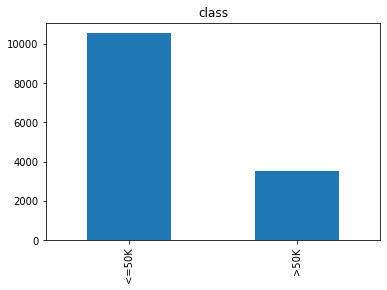

In [28]:
adult_set_for_training70, adult_testing70 = data_utils.data_split(adult_dataset, 70)
adult_training70, adult_validation70 = data_utils.split_training_data_for_pruning(adult_set_for_training70)

print(adult_training70['CLASS'].value_counts())
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

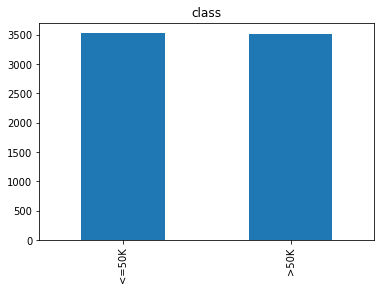

In [29]:
resampling_adult70 = adult_training70.copy()
less_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '<=50K']
more_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '>50K'] 

less_50k_part_downsampled70 = resample(less_50k_part70, 
                                 replace=False,    
                                 n_samples=3528)

# Combine minority class with downsampled majority class
balanced_adult_training70 = pd.concat([less_50k_part_downsampled70, more_50k_part70])
balanced_adult_training70 = balanced_adult_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training70 = balanced_adult_training70.sample(frac=1).reset_index(drop=True)

adult_training70 = balanced_adult_training70.copy()
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 80%

<=50K    12070
>50K      4015
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

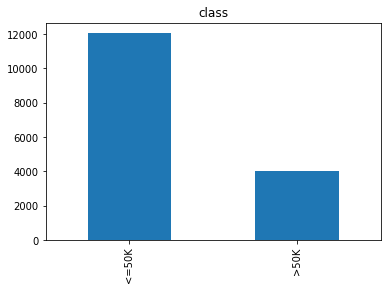

In [30]:
adult_set_for_training80, adult_testing80 = data_utils.data_split(adult_dataset, 80)
adult_training80, adult_validation80 = data_utils.split_training_data_for_pruning(adult_set_for_training80)

print(adult_training80['CLASS'].value_counts())
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

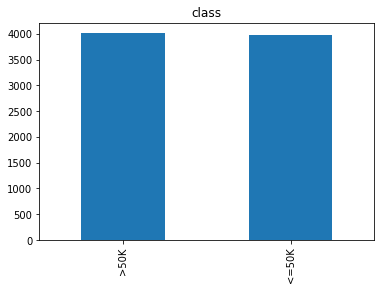

In [31]:
resampling_adult80 = adult_training80.copy()
less_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '<=50K']
more_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '>50K'] 

less_50k_part_downsampled80 = resample(less_50k_part80, 
                                 replace=False,    
                                 n_samples=3980)

# Combine minority class with downsampled majority class
balanced_adult_training80 = pd.concat([less_50k_part_downsampled80, more_50k_part80])
balanced_adult_training80 = balanced_adult_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training80 = balanced_adult_training80.sample(frac=1).reset_index(drop=True)

adult_training80 = balanced_adult_training80.copy()
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 90%

<=50K    13598
>50K      4498
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

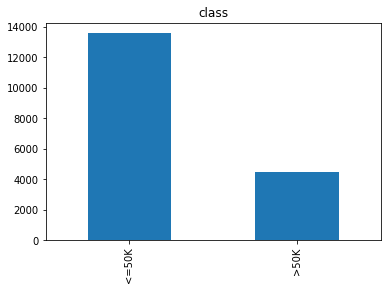

In [32]:
adult_set_for_training90, adult_testing90 = data_utils.data_split(adult_dataset, 90)
adult_training90, adult_validation90 = data_utils.split_training_data_for_pruning(adult_set_for_training90)

print(adult_training90['CLASS'].value_counts())
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

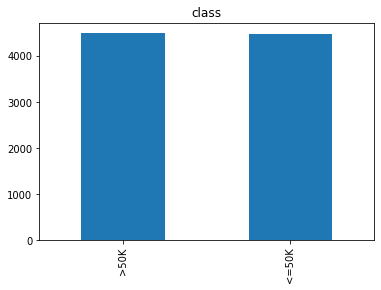

In [33]:
resampling_adult90 = adult_training90.copy()
less_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '<=50K']
more_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '>50K'] 

less_50k_part_downsampled90 = resample(less_50k_part90, 
                                 replace=False,    
                                 n_samples=4469)

# Combine minority class with downsampled majority class
balanced_adult_training90 = pd.concat([less_50k_part_downsampled90, more_50k_part90])
balanced_adult_training90 = balanced_adult_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training90 = balanced_adult_training90.sample(frac=1).reset_index(drop=True)

adult_training90 = balanced_adult_training90.copy()
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [ ]:
train_tree_for_different_heuristics(adult_training70, adult_testing70, adult_validation70)

In [ ]:
train_tree_for_different_heuristics(adult_training80, adult_testing80, adult_validation80)

In [ ]:
train_tree_for_different_heuristics(adult_training90, adult_testing90, adult_validation90)